In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import split
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.affinity import scale
from tqdm.auto import tqdm
pd.set_option('display.max_columns', None)

In [2]:
imd = gpd.read_file("input/IMD2018.zip")
df = imd.cx[1747618.6612:1768514.9720,5909569.6924:5922316.0159]
df = df[df.dhb2015_na == "Auckland"].copy()
df.set_index("DZ2018", inplace=True)
df.sample(1)

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7600991,564,6,3,Auckland,1,Auckland Central,76,Auckland,2,Auckland Region,2466,4,774.0,2,1678,3,4669,8,5601,10,4550,8,54,1,510,1,3112,6,2821,5,2299,4,1610,3,1939,4,2856,5,2568,5,"POLYGON ((1757632.916 5918932.992, 1757601.772..."


<Axes: >

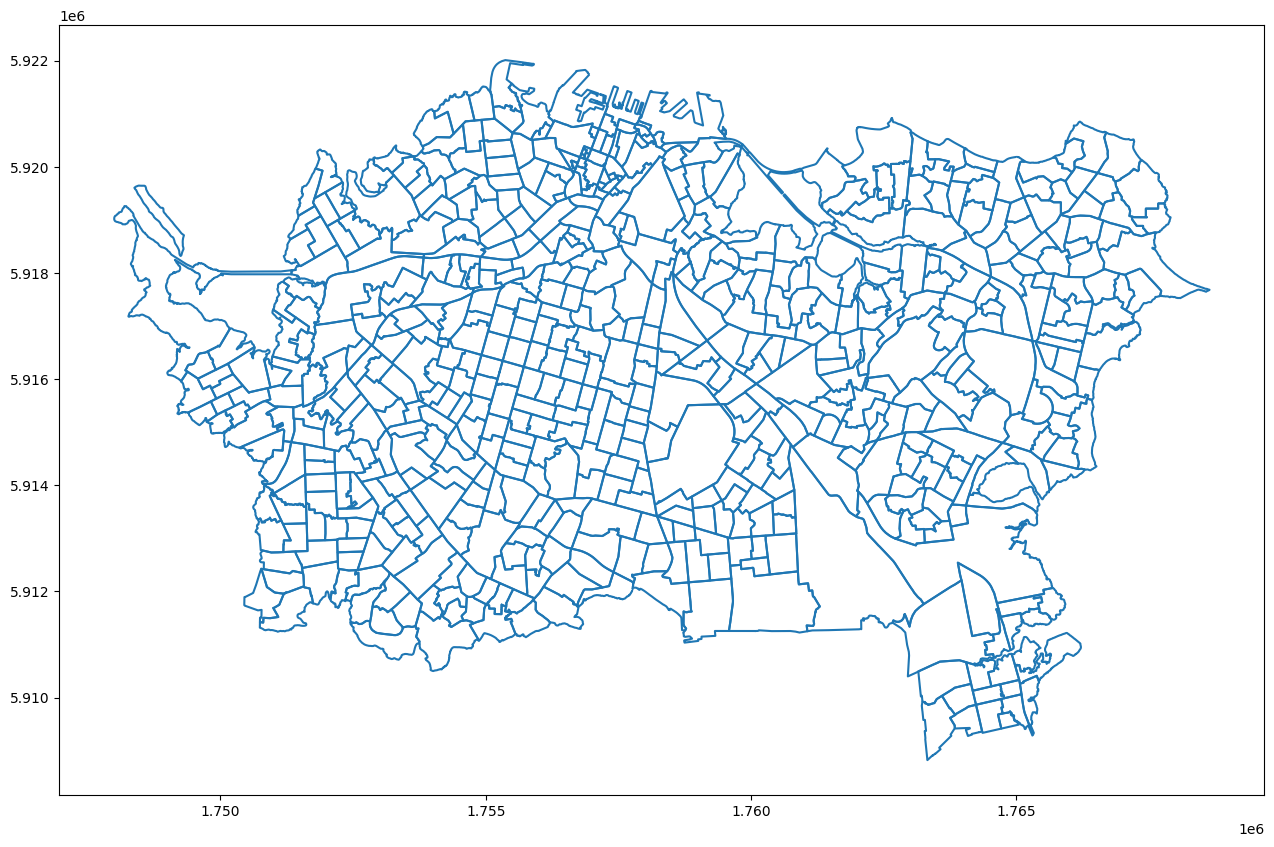

In [3]:
df.boundary.plot(figsize=(20,10))

Pull out one polygon to play with

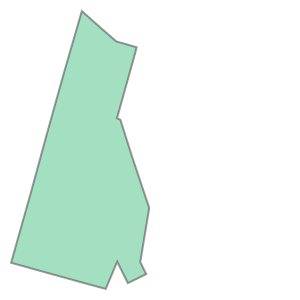

In [4]:
start = df.geometry.sample(1)
start_index = start.index[0]
start = start.iloc[0]
start

In [5]:
radius = start.centroid.distance(start.boundary)
radius

143.85933211610163

A hexagon is made of 6 equilateral triangles, with internal angles of 120 degrees. The internal angles of the equilateral triangles are all 60 degrees.

POLYGON ((1755333.0091371962 5913803.184741444, 1755261.0794711383 5913927.770577628, 1755117.220139022 5913927.770577628, 1755045.290472964 5913803.184741444, 1755117.220139022 5913678.59890526, 1755261.0794711383 5913678.59890526, 1755333.0091371962 5913803.184741444))


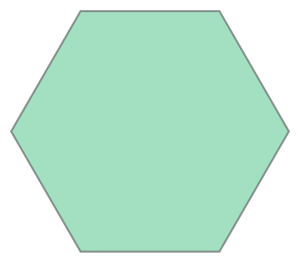

In [6]:
def create_hexagon(center, radius, rotate=False):
    """Create a hexagon centered at 'center' with a given 'radius', and include lines connecting each vertex to the center."""
    vertices = []
    for i in range(6):
        angle = math.radians(60 * i)  # Convert angle to radians
        if rotate:
            angle += math.radians(30)
        x = center.x + radius * math.cos(angle)  # X-coordinate
        y = center.y + radius * math.sin(angle)  # Y-coordinate
        vertices.append((x, y))  # Append vertex coordinates
    hexagon = Polygon(vertices)  # Create a polygon from the vertices
    return hexagon

start_hexagon = create_hexagon(start.centroid, radius)
assert start_hexagon.is_valid
print(start_hexagon)
start_hexagon

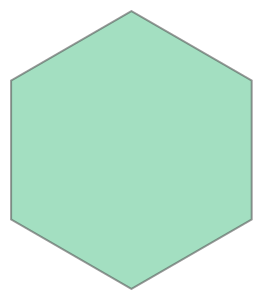

In [7]:
create_hexagon(start.centroid, radius, True)

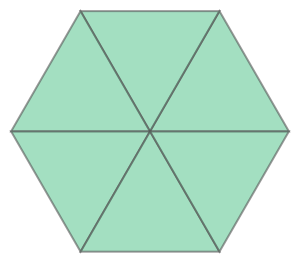

In [8]:
def hexagon_to_triangles(hexagon):
    center = hexagon.centroid
    vertices = list(hexagon.exterior.coords)
    triangles = []
    for i in range(6):
        next_i = (i + 1) % 6  # Wrap around to form a closed shape
        triangle = Polygon([center, vertices[i], vertices[next_i]])
        triangles.append(triangle)
    return GeometryCollection(triangles)

triangles = hexagon_to_triangles(start_hexagon)
assert triangles.is_valid
triangles

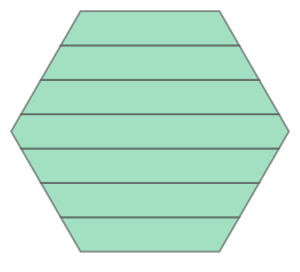

In [9]:
def slice_hexagon(hexagon, slices = 7):
  if hexagon is None:
    return None
  minx, miny, maxx, maxy = hexagon.bounds
  poly = hexagon
  segments = []
  slice_height = (maxy-miny) / slices
  for i in range(1, slices + 1):
    y = miny + slice_height * i
    parts = list(split(poly, LineString([(minx, y), (maxx, y)])).geoms)
    parts.sort(key=lambda p: p.bounds[1], reverse=True)
    #print(i, len(parts), [p.bounds[1] for p in parts], [p.area for p in parts])
    if len(parts) == 2:
      segments.append(parts[1])
      poly = parts[0]
    if i == slices:
      segments.append(parts[0])
  return GeometryCollection(segments)

slice_hexagon(start_hexagon)

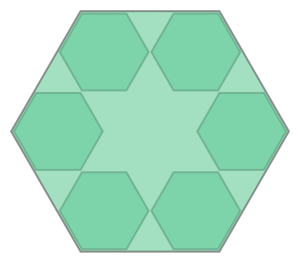

In [10]:
def sub_hexagons(hexagon):
    center = hexagon.centroid
    hexagons = []
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = start.centroid.x + radius * .66 * math.cos(angle)  # X-coordinate
        y = start.centroid.y + radius * .66 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .32))
    return GeometryCollection(hexagons)

GeometryCollection(list(sub_hexagons(start_hexagon).geoms) + [start_hexagon])

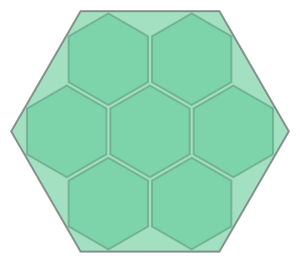

In [11]:
def sub_hexagons(hexagon):
    if hexagon is None:
        return None
    center = hexagon.centroid
    radius = start_hexagon.length / 6
    hexagons = [create_hexagon(center, radius * .33, True)]
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .6 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .6 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .33, True))
    return GeometryCollection(hexagons)

sub = sub_hexagons(start_hexagon)
GeometryCollection(list(sub.geoms) + [start_hexagon])

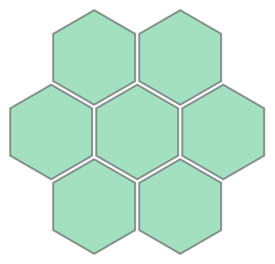

In [12]:
sub

<Axes: >

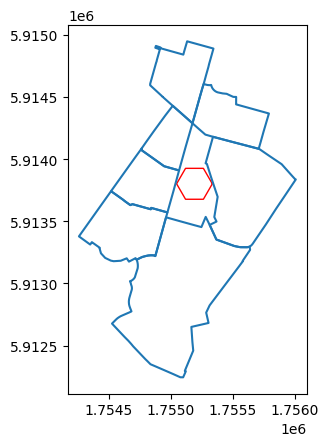

In [13]:
neighbours = df.geometry[df.touches(start)]
ax = neighbours.boundary.plot()
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

An equilateral triangle, split into two, makes two equal area triangles. The length of the line splitting the triangle, * 2, is the distance to the center of the neighbouring tesselated hexagon

124.58583618489851


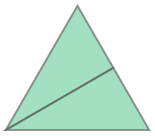

In [14]:
triangle = triangles.geoms[0]
v1, v2, v3 = set(triangle.exterior.coords)
midpoint = ((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
# Create a line from the midpoint to the opposite vertex
split_line = LineString([midpoint, v3])
print(split_line.length)
split_triangles = split(triangle, scale(split_line, yfact=1.001))
split_triangles

In [15]:
radius, split_line.length * 2

(143.85933211610163, 249.17167236979702)

<Axes: >

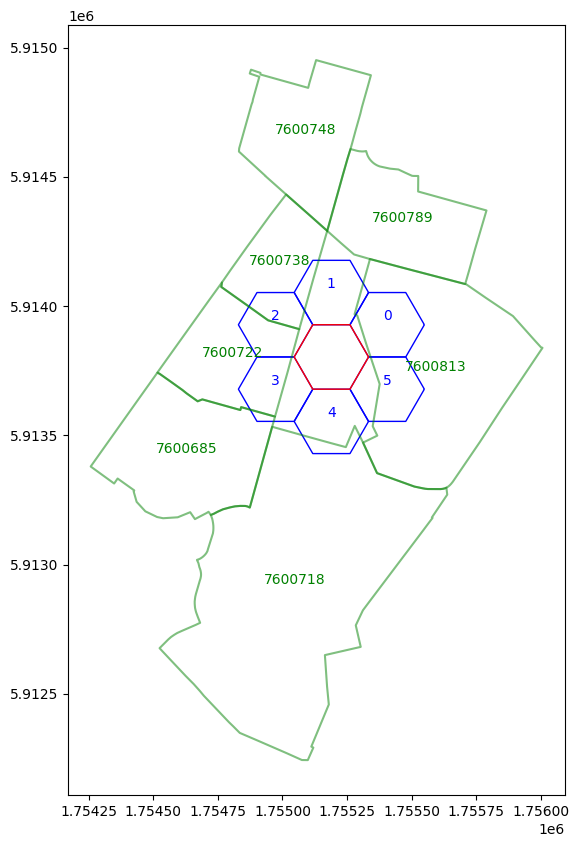

In [16]:
from shapely.geometry import Point
hex_neighbours = []
for i in range(6):
    angle = math.radians(60 * i + 30)  # Convert angle to radians
    x = start.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
    y = start.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
    hex_neighbours.append(create_hexagon(Point([x, y]), radius))

hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
ax = hex_neighbours.plot(edgecolor="blue", facecolor="none", figsize=(10,10))
for i in range(6):
  p = hex_neighbours.centroid.iloc[i]
  ax.annotate(text=str(i), xy=[p.x, p.y + radius / 8], ha='center', color="blue")
neighbours.boundary.plot(ax=ax, color="green", alpha=.5)
for i in neighbours.index:
  ax.annotate(text=str(i), xy=[neighbours.centroid[i].x, neighbours.centroid[i].y], ha='center', color="green")
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

                   0            1            2           3            4  \
DZ2018                                                                    
7600685   921.216072   836.054912   603.761476  423.933082   573.908087   
7600718  1064.232109  1135.831282  1005.088187  756.815107   644.396141   
7600722   609.458370   454.639057   206.250727  207.665318   455.925121   
7600738   476.045544   226.984549   229.946558  478.880182   635.943082   
7600748   800.710352   619.682630   745.599959  992.452791  1114.492283   
7600789   403.154162   389.989296   634.239757  814.168358   820.555753   
7600813   259.713366   505.343448   645.165730  623.846671   448.624231   

                   5  
DZ2018                
7600685   814.757871  
7600718   833.760652  
7600722   609.938543  
7600738   634.878074  
7600748  1034.495197  
7600789   650.494677  
7600813   200.989757  


<Axes: ylabel='DZ2018'>

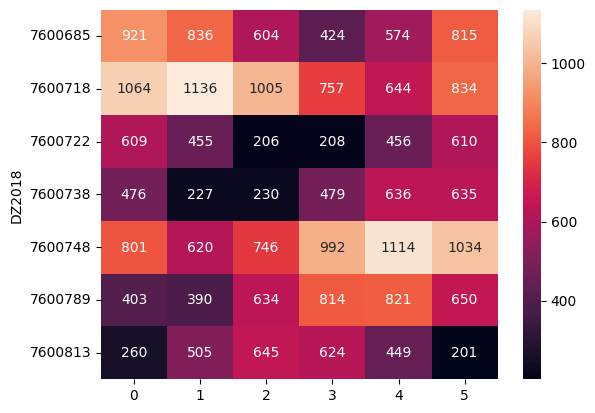

In [17]:
# Build a cost distance matrix
distance_matrix = neighbours.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
print(distance_matrix)
sns.heatmap(distance_matrix.round(), annot=True, fmt=".0f")

In [18]:
df["hex_geo"] = gpd.GeoSeries()
df.loc[start_index, "hex_geo"] = start_hexagon

In [19]:
row_ind, col_ind = linear_sum_assignment(distance_matrix)
distance_matrix.index[row_ind], hex_neighbours[col_ind]
df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

In [20]:
pbar = tqdm(total=sum(df.hex_geo.isna()))

def assign_neighbours(neighbour_index):
   geometry = df.geometry[neighbour_index]
   # Recursive function, takes a geometry and assigns hexagons to its neighbours
   neighbours = df.geometry[df.touches(geometry)]
   neighbours_to_process = set()
   for neighbour_index in neighbours.index:
      neighbour = neighbours[neighbour_index]
      neighbour_hex = df.hex_geo[neighbour_index]
      if not neighbour_hex:
          continue
      nn = df.geometry[df.hex_geo.isna() & df.touches(neighbour)]
      if len(nn) == 0:
         # No neighbours
         continue
      hex_neighbours = []
      for i in range(6):
            angle = math.radians(60 * i + 30)  # Convert angle to radians
            x = neighbour_hex.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
            y = neighbour_hex.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
            hex = create_hexagon(Point([x, y]), radius)
            # Filter out already used hexagons
            if df.hex_geo.centroid.distance(hex.centroid).min() > 1:
               hex_neighbours.append(hex)

      if len(hex_neighbours) == 0:
         # No available hexagons
         continue
      hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
      neighbours_to_process.update(nn.index)
      # Build a cost distance matrix
      distance_matrix = nn.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
      row_ind, col_ind = linear_sum_assignment(distance_matrix)
      # Assign the optimal hexagons to each neighbour
      df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values
      pbar.update(len(col_ind))
   for neighbour in neighbours_to_process:
       assign_neighbours(neighbour)

assign_neighbours(start_index)
pbar.close()
print(f"Assigned hexagons for {sum(~df.hex_geo.isna())} out of {len(df)} DZs")

  0%|          | 0/574 [00:00<?, ?it/s]

Assigned hexagons for 580 out of 581 DZs


In [21]:
rank_cols = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi', 'Rank_Healt', 'Rank_Educa', 'Rank_Acces']

In [22]:
df["sliced_hexagons"] = df.hex_geo.apply(slice_hexagon)
df["sub_hexagons"] = df.hex_geo.apply(sub_hexagons)

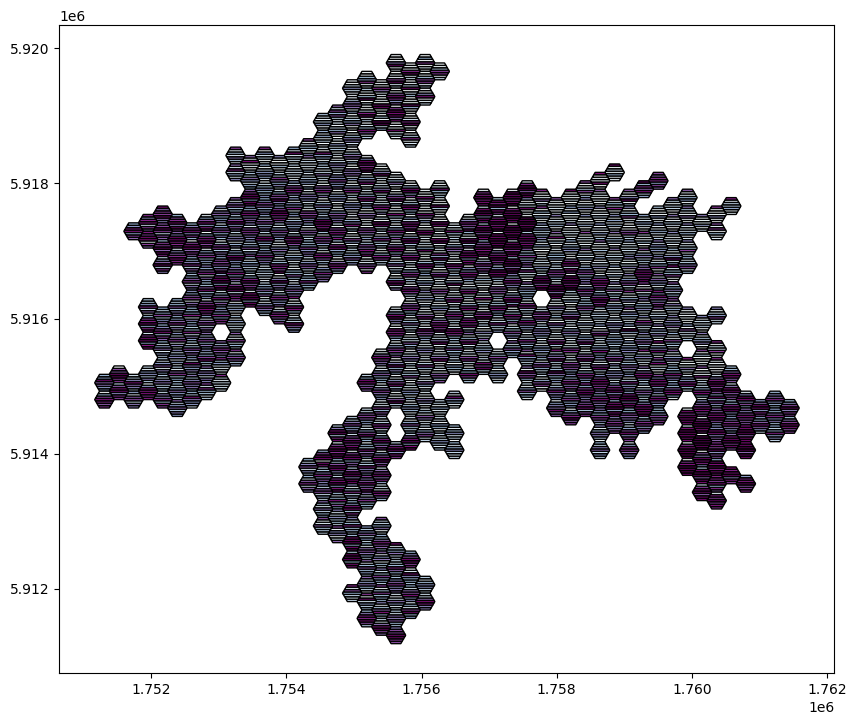

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sliced_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

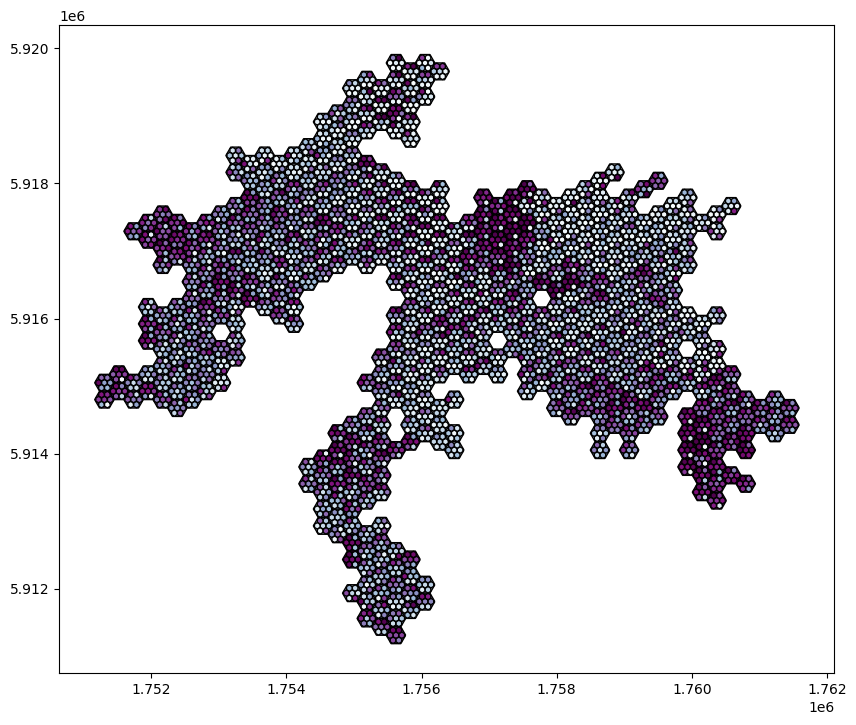

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

df.set_geometry(df.hex_geo).plot("Rank_IMD18", ax=ax, cmap="BuPu", edgecolor="black")
for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sub_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

In [25]:
df.set_geometry(df.hex_geo).explore()